# Visualizing the Pix2Pix results

Once trained, let's visualize some results from our Pix2Pix model. To do so we just need to load a generator model and feed it with a "source image". Here you will need to provide an image that is compatible with the source you trained on. E.g if you trained an edge-to-"something" model, your input should be edges. This notebook is setup to load one of the pre-trained model we provide. One transforms face landmarks into "Rembrandt paintings", and one transforms face edges into "comics drawings". First let's see how to do this in a notebook 

## Visualizing the results in a notebook
As usual, lets do some importing and setup the torch device

In [2]:
import numpy as np
import cv2
from skimage import feature, io, transform
import matplotlib.pyplot as plt
import torch
import sys, os

# Try chaning 'cpu' to 'mps' if using mac M1/M2, may speed up things
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
if device == 'mps':
    torch.set_default_tensor_type(torch.FloatTensor)

We then need to define code to load the model and to generate images with the model given an input. We saved TorchScript models so we load a model with

In [3]:
def load_model(model_path):
    return torch.jit.load(os.path.expanduser(model_path), map_location=device)

# This could would load a normal checkpoint (.pth file), but would require the code for the model (e.g. the Generator class in this case)
# def load_model(path):
#     checkpoint = torch.load(path)
#     model = checkpoint['model']
#     model.load_state_dict(checkpoint['model_state'])
#     model.eval()
#     return model


# Do not 'eval', which will usually "freeze" batch normalization and dropout layers  that would block meaning that we still use the dropout layers
# https://arxiv.org/pdf/1607.08022.pdf
#generator.eval()



Then let's define a function that generates a target image given a RGB input:


In [4]:
def generate_image(model, img):
    img = torch.tensor((img/255)*2.0 - 1.0, 
                       dtype=torch.float32).to(device) # Scale to -1, 1
    # Convert to torch batch form (NCHW)
    img = img[:, :, :, np.newaxis]
    img = img.permute(3, 2, 0, 1)
    res = model(img)[0].permute(1, 2, 0)
    return (res*0.5 + 0.5).detach().cpu().numpy()


The image expects an RGB input with three channels ranging 0 to 255 with a shape (H, W, 3). For feeding it to the model we need to scale the input to the [-1, 1] range and then convert it to the shape (1, 3, H, W) where the first element of the shape is a batch number. Once the image is generated we rescale it to a [0, 1] range and convert it to the shape (H, W, 3)




### Landmarks to Rembrant

Let's first test the face landmarks to Rembrandt painting model, which you can download here:

Copy the ".pt" file to the `models` directory relative to this notebook and make sure that the `model_path` variable is set to the correct path:


In [5]:
model_path = './models/edge2rembrandt_195_generator.pt'
generator = load_model(model_path)

Now let's write a function that finds landmarks in an input image using the [face_recognition](https://pypi.org/project/face-recognition/) package and then uses the [Canvas API](https://github.com/colormotor/py5canvas) to create the face landmarks and draw them into an image (as we did in the dataset creation notebook). We will then apply the landmarks to an example input image:

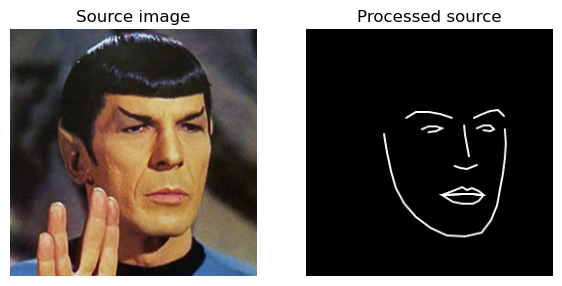

In [6]:
def apply_face_landmarks(img, stroke_weight=2):
    from py5canvas import canvas
    import face_recognition
    
    c = canvas.Canvas(256, 256)
    c.background(0)
    landmarks = face_recognition.face_landmarks(img)

    if not landmarks:
        # print('Failed to find landmarks')
        return None
    c.stroke_weight(stroke_weight)
    c.no_fill()
    c.stroke(255)
    for points in landmarks[0].values():
        c.polyline(points)
    return c.get_image()

img = io.imread('images/spock.jpg')
# Resize image to 256x256 (might stretch if image is not square)
# img = transform.resize(img, (256, 256), preserve_range=True).astype(np.uint8)
source_img = apply_face_landmarks(img)

plt.figure(figsize=(7,4))
plt.subplot(1, 2, 1)
plt.title('Source image')
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Processed source')
plt.axis('off')
plt.imshow(source_img)
plt.show()

Finally let's apply the pix2pix model to the processed source image and look at the result 

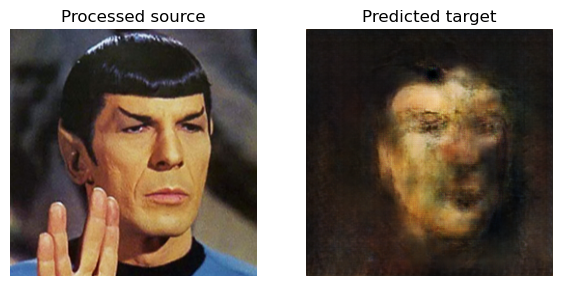

In [7]:
target = generate_image(generator, source_img)

plt.figure(figsize=(7,4))
plt.subplot(1, 2, 1)
plt.title('Processed source')
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Predicted target')
plt.imshow(target)
plt.axis('off')
plt.show()

The result is not great. The reason for this is that most of the images in the training set have rather small faces! So the model has not generalized well how to "translate" a larger face image. You could fix this by using the face landmarks to zoom into areas that contain a face when generating the training data. But one workaround to get a better result is to use an image with a smaller face:


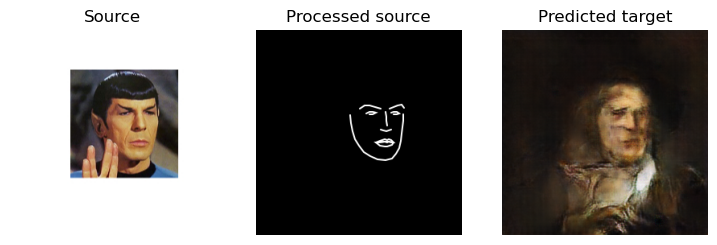

In [8]:
img = io.imread('images/spocksmall.jpg')
source_img = apply_face_landmarks(img)
target = generate_image(generator, source_img)

plt.figure(figsize=(9,4))
plt.subplot(1, 3, 1)
plt.title('Source')
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('Processed source')
plt.imshow(source_img)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Predicted target')
plt.imshow(target)
plt.axis('off')
plt.show()


### Edges to comics
Now let's try a similar procedure with the Edge to comics. 
Again, to test this you can download a pre-trained model for the 100th epoch here: 
https://enist.org/dmlap_models/edges2comics.zip
Copy and unzip to a `models` folder at the same level as this notebook to run this without modifications.

Now let's load the model

In [9]:
model_path = './models/edge2comics_11_generator.pt'
generator = load_model(model_path)

This time we use the canny edge detector to transform the input image (again similarly to the dataset creation notebook):

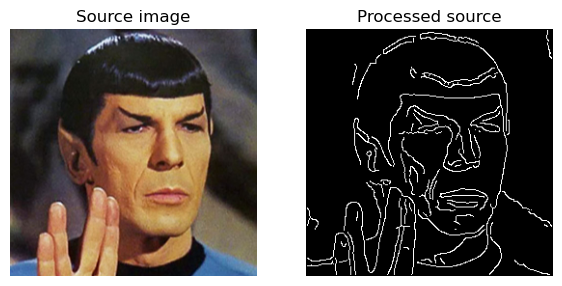

In [10]:
def apply_canny_skimage(img, sigma=1.5):
    import cv2
    from skimage import feature
    invert = False
    grayimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = (feature.canny(grayimg, sigma=sigma)*255).astype(np.uint8)
    if invert:
        edges = cv2.bitwise_not(edges)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

img = io.imread('images/spock.jpg')
# Resize image to 256x256 (might stretch if image is not square)
# img = transform.resize(img, (256, 256), preserve_range=True).astype(np.uint8)
source_img = apply_canny_skimage(img)

plt.figure(figsize=(7,4))
plt.subplot(1, 2, 1)
plt.title('Source image')
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Processed source')
plt.axis('off')
plt.imshow(source_img)
plt.show()

And again apply a similar procecss to transform our input

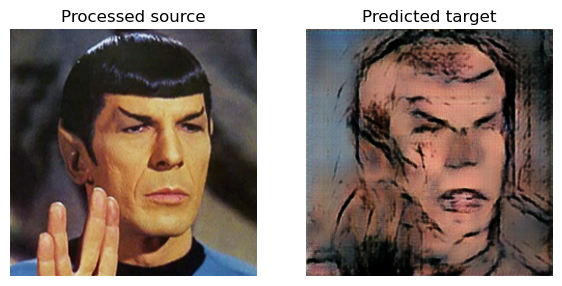

In [11]:
target = generate_image(generator, source_img)

plt.figure(figsize=(7,4))
plt.subplot(1, 2, 1)
plt.title('Processed source')
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Predicted target')
plt.imshow(target)
plt.axis('off')
plt.show()

# Facades 

Let's try now with the "facade" dataset (one of the official pix2pix datasets). In this case, the transformation that has been used is a bit more sophisticated than the ones we exposed so far. The source images are semantic annotations of the image of a facade, with specific colors labelling specific features, e.g. "window", "door" etc...

You can train the model by downloading the dataset [here](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/) or download a pre-trained model here:
https://enist.org/dmlap_models/facades.zip
If you download the pre-trained model, unzip it and copy it to the `models` folder at the same level as this notebook to run this without modifications.

Let's load the model as usual:

In [32]:
model_path = './models/facades_150_generator.pt'
generator = load_model(model_path)

The color map for the facades is based on the ["jet" color map](https://matplotlib.org/stable/tutorials/colors/colormaps.html), which maps continuous values between 0 and 1 to a color palette. See [this document](https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_2013.pdf) for details on what each color means. Matplotlib gives us easy access to these colors

In [33]:
import matplotlib

def jet_color(v):
    c = matplotlib.cm.get_cmap('jet')
    return np.array(c(v))*255 # The output of this function is between 0 and 1, we will use 0 to 255 colors

Here we will use the Canvas API directly to generate some random rectangles filled with randomly selected colors from the palette. The labels are (should be) organized as follows:
0. background
1. facade
2. window
3. door
4. cornice
5. sill
6. balcony
7. blind
8. deco
9. molding
10. pillar
11. shop

We will also use the Canvas API instead of Matplotlib, to draw the result produced by the model:

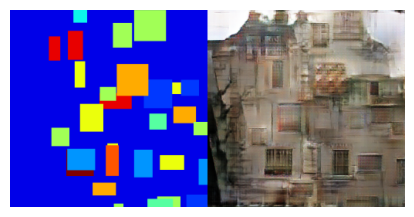

In [37]:
from py5canvas import canvas

# this gives us values between 0 and 1 for the labels
labels = np.linspace(0, 1, 12)

def random_label():   
    #return labels[np.random.choice([2, 3, 6, 8, 10])] # place here the labels you want to randomly choose from
    return np.random.choice(labels[2:]) # simply excludes background and facade
    #return np.random.uniform(0.1, 1.0)

c = canvas.Canvas(512, 256) # Half canvas for source, half canvas for predicted target
c.background(jet_color(0)) # Fill with the darkest color (background)
c.no_stroke()

# Draw the main facade
pad = 0
c.fill(jet_color(labels[1]))
c.rect(pad, pad, 256-pad*2, 256)

# Draw some random rectangle with random feature colors
for i in range(30):
    c.fill(jet_color(random_label()))
    c.rect(np.random.uniform(pad, c.height-pad*2, size=2), np.random.uniform(2, 7, size=2)*6)
    #c.fill(jet_color(random_label()))
    #c.circle(np.random.uniform(pad, c.height-pad, size=2), np.random.uniform(5, c.height*0.15)*0.5) #, size=2))
# Get the left half of the canvas we have drawn so far, and place it into an image
img = c.get_image()[:, :256]
# Then use this as an input to the model and draw the output in the right half
result = generate_image(generator, img)
c.image(result, [256, 0])
c.show()

## Interactive viewing

To interactively view the pix2pix results you will need to install [Py5Canvas](https://github.com/colormotor/py5canvas).


Then copy the `pix2pix_draw.py`, `pix2pix_edges.py`, `pix2pix_face_landmarks.py`, `pix2pix_graphics.py` scripts provided in the `py5sketches` directory of the DMLAP repository to your preferred location (e.g. your project directory) and open a terminal. Preferably, put the scripts into a subdirectory so the paths in the scripts are consistent with your personal directory layout. 

- The first script `pix2pix_draw.py` let's you draw scribbles that are then transformed by the given model, when pressing the spacebar. To clear the drawing press "c".
- The second script `pix2pix_edges.py` performs edge detection on the webcam input and then uses the specified model to transform the edges.
- The third script `pix2pix_face_landmarks.py` finds and draws face landmarks from the webcam input and then uses the specified model to transform the landmarks. If not landmarks are found the script will simply visualize the webcam input.
- The fourth script `pix2pix_graphics.py` draws an animation using white stroke on a black background and then passes each frame to a given pix2pix model.


To run, open a terminal and use `cd` to navigate to the directory where you placed
 the scripts and then activate your conda environment (e.g. with `conda activate dmlap` if that is what you called the environment). Finally run the script. For example to run `pix2pix_draw.py`
 ```
 py5sketch pix2pix_draw.py
 ``` 
In the `pix2pix_draw.py` script (or the one you choose to run) you can modify the variable `model_path` so it points to the `hd5` file for the model you want to test.